---
title: "Data Analysis"
subtitle: "Comprehensive Data Cleaning & Exploratory Analysis of Job Market Trends"
date-modified: today
date-format: long

#bibliography: references_analysis.bib
csl: csl/econometrica.csl
#nocite: '@*'  #show all references
format:
  html:
    toc: true
    number-sections: true
    df-print: paged
---

Import required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

Load the dataset

In [2]:
df = pd.read_csv("data/lightcast_job_postings.csv")

1.  Data Cleaning & Preprocessing



  1.1 Drop Unnecessary Columns

  Many variables in the dataset has two columns, one is code name of the variable, and the other is the real name of the variable. We will delete all the columns with code name of the variables, since they are meaningless. For example, we have a job "Data analysts", we do not need to know whether its code name is "10001", or "A-001", or something like this, because it's useless and there's no real significance to it, we can change these code names at will.

  Also, columns like "LAST_UPDATED_TIMESTAMP", duplicates the meaning of the other variable "LAST_UPDATED_DATE". Since we basically only need to know the last update date, and don't have to be specific to a moment in that day, we'll remove such columns as well.  

  We remove redundant ONET/NAICS/SOC/LOR codes and tracking data to simplify our dataset. Keeping only the latest ONET_2019, NAICS_2022_6, SOC_2021_5, and LOT_V6 ensures that our analysis reflects current industry and occupational classifications.


In [3]:
columns_to_drop = ["ID", "URL", "ACTIVE_URLS", "DUPLICATES", "LAST_UPDATED_TIMESTAMP", "ACTIVE_SOURCES_INFO",
"TITLE_RAW", "COMPANY", "COMPANY_RAW", "EDUCATION_LEVELS", "MIN_EDULEVELS", "MAX_EDULEVELS",
"EMPLOYMENT_TYPE", "REMOTE_TYPE", "CITY", "COUNTY", "MSA", "STATE", "COUNTY_OUTGOING",
"COUNTY_INCOMING", "MSA_OUTGOING", "MSA_INCOMING", "NAICS2", "NAICS2_NAME", "NAICS3", "NAICS3_NAME",
"NAICS4", "NAICS4_NAME", "NAICS5", "NAICS5_NAME", "NAICS6", "NAICS6_NAME", "TITLE", "TITLE_CLEAN",
"SKILLS", "SPECIALIZED_SKILLS", "CERTIFICATIONS", "COMMON_SKILLS", "SOFTWARE_SKILLS", "ONET", "ONET_NAME",
"ONET_2019", "CIP6", "CIP4", "CIP2", "SOC_2021_2", "SOC_2021_2_NAME", "SOC_2021_3", "SOC_2021_3_NAME",
"SOC_2021_4", "SOC_2021_4_NAME", "SOC_2021_5", "LOT_CAREER_AREA", "LOT_CAREER_AREA_NAME", "LOT_OCCUPATION",
"LOT_OCCUPATION_NAME", "LOT_SPECIALIZED_OCCUPATION", "LOT_SPECIALIZED_OCCUPATION_NAME", "LOT_OCCUPATION_GROUP",
"LOT_OCCUPATION_GROUP_NAME", "LOT_V6_SPECIALIZED_OCCUPATION", "LOT_V6_OCCUPATION", "LOT_V6_OCCUPATION_GROUP",
"LOT_V6_CAREER_AREA", "SOC_2", "SOC_2_NAME", "SOC_3", "SOC_3_NAME", "SOC_4", "SOC_4_NAME", "SOC_5",
"SOC_5_NAME", "LIGHTCAST_SECTORS", "NAICS_2022_2", "NAICS_2022_2_NAME", "NAICS_2022_3", "NAICS_2022_3_NAME",
"NAICS_2022_4", "NAICS_2022_4_NAME", "NAICS_2022_5", "NAICS_2022_5_NAME", "NAICS_2022_6"]
df.drop(columns=columns_to_drop, inplace=True)

  1.2 Handle Missing Values

  We use different strategies for missing values:

  - Numerical fields (e.g., Salary) are filled with the median.
  - Categorical fields (e.g., Company Name) are replaced with "Unknown".
  - Columns with >50% missing values are dropped.

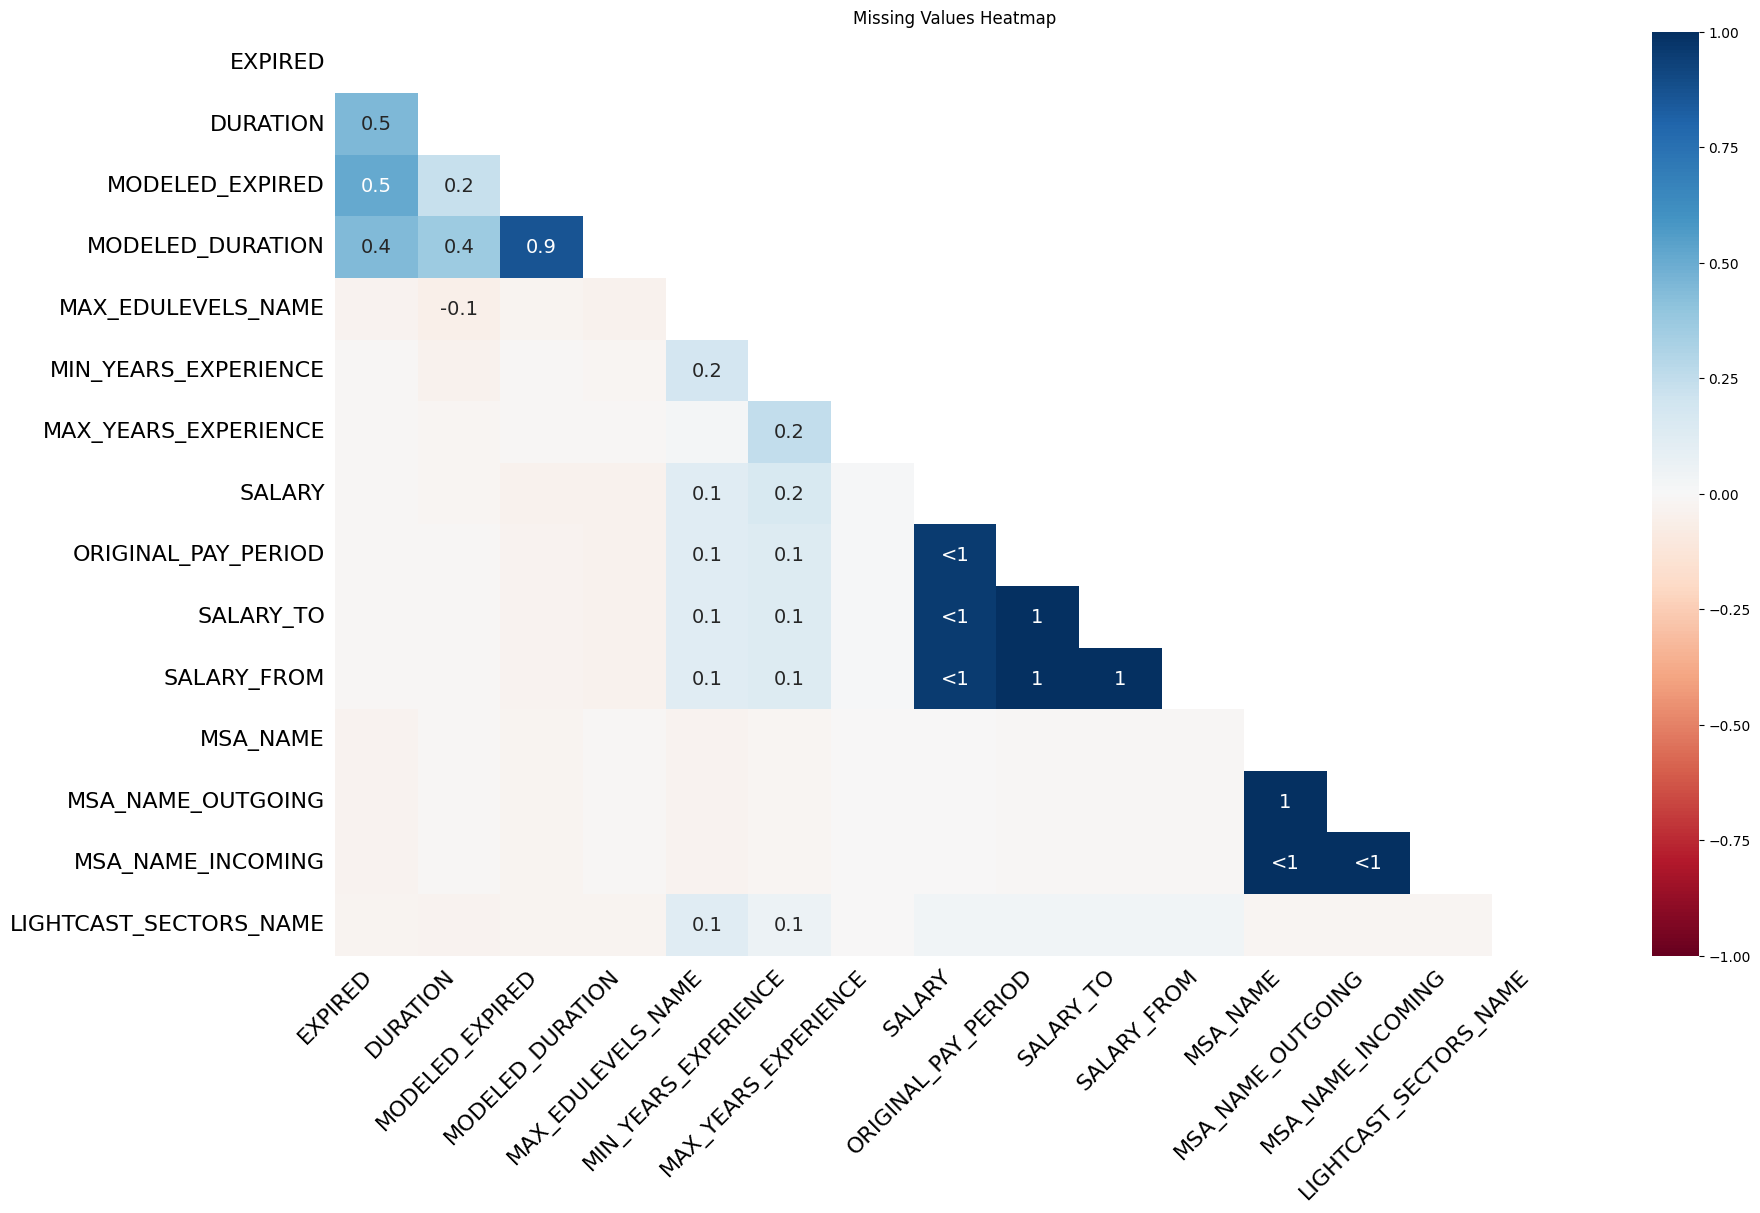

In [4]:
# Visualize missing data
msno.heatmap(df)
plt.title("Missing Values Heatmap")
plt.show()

#plt.savefig("./images/missing_data.png")  ##save the pic

In [5]:
# Drop columns with >50% missing values
df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)

# Fill missing values
def fill_missing_values(df):
    for col in df.select_dtypes(include=['number']).columns:
        df[col] = df[col].fillna(df[col].median()) 
    for col in df.select_dtypes(exclude=['number']).columns:
        df[col] = df[col].fillna("Unknown")  
    return df

fill_missing_values(df)

,LAST_UPDATED_DATE,POSTED,EXPIRED,DURATION,SOURCE_TYPES,SOURCES,BODY,MODELED_EXPIRED,MODELED_DURATION,COMPANY_NAME,...,ONET_2019_NAME,CIP6_NAME,CIP4_NAME,CIP2_NAME,SOC_2021_5_NAME,LOT_V6_SPECIALIZED_OCCUPATION_NAME,LOT_V6_OCCUPATION_NAME,LOT_V6_OCCUPATION_GROUP_NAME,LOT_V6_CAREER_AREA_NAME,NAICS_2022_6_NAME
0,2024-09-06,2024-06-02,2024-06-08,6.0,"[\n ""Company""\n]","[\n ""brassring.com""\n]",31-May-2024\n\nEnterprise Analyst (II-III)\n\n...,2024-06-08,6.0,Murphy USA,...,Business Intelligence Analysts,"[\n ""Economics, General"",\n ""Mathematics, Ge...","[\n ""Economics"",\n ""Mathematics""\n]","[\n ""Social Sciences"",\n ""Mathematics and St...",Data Scientists,General ERP Analyst / Consultant,Business Intelligence Analyst,Business Intelligence,Information Technology and Computer Science,Automotive Parts and Accessories Retailers
1,2024-08-02,2024-06-02,2024-08-01,18.0,"[\n ""Job Board""\n]","[\n ""maine.gov""\n]",Oracle Consultant - Reports (3592)\n\nat SMX i...,2024-08-01,16.0,Smx Corporation Limited,...,Business Intelligence Analysts,[],[],[],Data Scientists,Oracle Consultant / Analyst,Business Intelligence Analyst,Business Intelligence,Information Technology and Computer Science,Temporary Help Services
2,2024-09-06,2024-06-02,2024-07-07,35.0,"[\n ""Job Board""\n]","[\n ""dejobs.org""\n]",Taking care of people is at the heart of every...,2024-06-10,8.0,Sedgwick,...,Business Intelligence Analysts,[],[],[],Data Scientists,Data Analyst,Data / Data Mining Analyst,Data Analysis and Mathematics,Information Technology and Computer Science,Claims Adjusting
3,2024-09-06,2024-06-02,2024-07-20,48.0,"[\n ""Job Board""\n]","[\n ""disabledperson.com"",\n ""dejobs.org""\n]",About this role:\n\nWells Fargo is looking for...,2024-06-12,10.0,Wells Fargo,...,Business Intelligence Analysts,[],[],[],Data Scientists,Data Analyst,Data / Data Mining Analyst,Data Analysis and Mathematics,Information Technology and Computer Science,Commercial Banking
4,2024-06-19,2024-06-02,2024-06-17,15.0,"[\n ""FreeJobBoard""\n]","[\n ""craigslist.org""\n]",Comisiones de $1000 - $3000 por semana... Comi...,2024-06-17,15.0,Unclassified,...,Business Intelligence Analysts,[],[],[],Data Scientists,Oracle Consultant / Analyst,Business Intelligence Analyst,Business Intelligence,Information Technology and Computer Science,Unclassified Industry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72471,2024-09-06,2024-08-16,2024-08-31,15.0,"[\n ""Job Board""\n]","[\n ""dejobs.org""\n]",TEKsystems\n\n \n \n \n\n \n\n \nData Analyst\...,2024-08-31,15.0,TEKsystems,...,Business Intelligence Analysts,"[\n ""Business/Commerce, General""\n]","[\n ""Business/Commerce, General""\n]","[\n ""Business, Management, Marketing, and Rel...",Data Scientists,Data Analyst,Data / Data Mining Analyst,Data Analysis and Mathematics,Information Technology and Computer Science,Custom Computer Programming Services
72472,2024-10-21,2024-08-16,Unknown,18.0,"[\n ""Company"",\n ""Job Board""\n]","[\n ""myworkdayjobs.com"",\n ""mass-veterans.jo...",Lead Enterprise Architect - SalesForce \nLead ...,2024-09-13,28.0,Wolters Kluwer,...,Business Intelligence Analysts,"[\n ""Business Administration and Management, ...","[\n ""Business Administration, Management and ...","[\n ""Business, Management, Marketing, and Rel...",Data Scientists,Enterprise Architect,Computer Systems Engineer / Architect,Network and Systems Engineering,Information Technology and Computer Science,Book Publishers
72473,2024-10-16,2024-08-16,2024-09-22,37.0,"[\n ""Job Board"",\n ""Company""\n]","[\n ""disabledperson.com"",\n ""dejobs.org""\n]",Volt\n\n \n \n \n\n \n\n \nData Analyst\n in\n...,2024-08-31,15.0,Volt,...,Business Intelligence Analysts,"[\n ""Data Analytics, General"",\n ""Statistics...","[\n ""Data Analytics"",\n ""Statistics"",\n ""Co...","[\n ""Multi/Interdisciplinary Studies"",\n ""Ma...",Data Scientists,Data Analyst,Data / Data Mining Analyst,Data Analysis and Mathematics,Information T

1.3 Remove Duplicates

To ensure each job is counted only once, we remove duplicates based on job title, company, location, and posting date.

In [6]:
df = df.drop_duplicates(subset=["TITLE_NAME", "COMPANY_NAME", "LOCATION", "POSTED"], keep="first")

2. Exploratory Data Analysis (EDA)

1. Comparison of salary between remote and on-site work (box chart)

First clean up REMOTE_TYPE_NAME, split all data into field, remote, and hybrid, and then plot.

In [9]:
#Convert values to string and clean unnecessary characters
df["REMOTE_TYPE_NAME"] = df["REMOTE_TYPE_NAME"].astype(str).str.replace(r"[\[\]']", "", regex=True).str.strip()

### Standardize Remote Work Types
df["REMOTE_TYPE_NAME"] = df["REMOTE_TYPE_NAME"].replace({
    "None": "On-Site",  
    "Not Remote": "On-Site",
    "Hybrid Remote": "Hybrid",
    "Remote": "Remote"
})

/tmp/ipykernel_4163/2955443620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["REMOTE_TYPE_NAME"] = df["REMOTE_TYPE_NAME"].astype(str).str.replace(r"[\[\]']", "", regex=True).str.strip()
/tmp/ipykernel_4163/2955443620.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["REMOTE_TYPE_NAME"] = df["REMOTE_TYPE_NAME"].replace({


In [10]:
#Remove invalid values (numbers and locations)
valid_remote_types = ["On-Site", "Hybrid", "Remote"]
df = df[df["REMOTE_TYPE_NAME"].isin(valid_remote_types)]

In [11]:
import plotly.express as px

fig = px.box(df, x="REMOTE_TYPE_NAME", y="SALARY",
             title="Salary Comparison: Remote vs. On-Site Jobs",
             category_orders={"REMOTE_TYPE_NAME": ["On-Site", "Hybrid", "Remote"]},
             labels={"REMOTE_TYPE_NAME": "Job Type", "SALARY": "Salary ($)"})
fig.show()
plt.savefig("./images/box_chart.png")  ##save the pic

ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of ['LAST_UPDATED_DATE', 'POSTED', 'EXPIRED', 'DURATION', 'SOURCE_TYPES', 'SOURCES', 'BODY', 'MODELED_EXPIRED', 'MODELED_DURATION', 'COMPANY_NAME', 'COMPANY_IS_STAFFING', 'EDUCATION_LEVELS_NAME', 'MIN_EDULEVELS_NAME', 'EMPLOYMENT_TYPE_NAME', 'MIN_YEARS_EXPERIENCE', 'IS_INTERNSHIP', 'REMOTE_TYPE_NAME', 'LOCATION', 'CITY_NAME', 'COUNTY_NAME', 'MSA_NAME', 'STATE_NAME', 'COUNTY_NAME_OUTGOING', 'COUNTY_NAME_INCOMING', 'MSA_NAME_OUTGOING', 'MSA_NAME_INCOMING', 'TITLE_NAME', 'SKILLS_NAME', 'SPECIALIZED_SKILLS_NAME', 'CERTIFICATIONS_NAME', 'COMMON_SKILLS_NAME', 'SOFTWARE_SKILLS_NAME', 'ONET_2019_NAME', 'CIP6_NAME', 'CIP4_NAME', 'CIP2_NAME', 'SOC_2021_5_NAME', 'LOT_V6_SPECIALIZED_OCCUPATION_NAME', 'LOT_V6_OCCUPATION_NAME', 'LOT_V6_OCCUPATION_GROUP_NAME', 'LOT_V6_CAREER_AREA_NAME', 'NAICS_2022_6_NAME'] but received: SALARY

2. Salary by region (map)

Originally, the state names in "STATE_NAME" were all full names, so abbreviate them before drawing them

In [ ]:
#Convert full state names to abbreviations
import us
df["STATE_NAME"] = df["STATE_NAME"].apply(lambda x: us.states.lookup(x).abbr if pd.notna(x) else x)

In [ ]:
#Verify conversion
print(df["STATE_NAME"].unique())  # Should now contain abbreviations like 'CA', 'TX', 'ME'

import plotly.express as px

fig = px.choropleth(df, 
                    locations="STATE_NAME", 
                    locationmode="USA-states",
                    color="SALARY", 
                    hover_name="STATE_NAME",
                    scope="usa", 
                    title="Average Salary by State",
                    color_continuous_scale="Viridis",
                    labels={"SALARY": "Average Salary ($)"})

fig.show()
plt.savefig("./images/map.png")  ##save the pic

3. The highest paying job

In [ ]:
fig = px.bar(df.groupby("LIGHTCAST_SECTORS_NAME")["SALARY"].mean().sort_values(ascending=False).head(10),
             title="Top 10 Industries with Highest Salaries",
             labels={"LIGHTCAST_SECTORS_NAME": "Industry", "SALARY": "Salary ($)"})
fig.show()
plt.savefig("./images/highest_paying_job.png")  ##save the pic

4. Salary comparison between AI and non-AI positions

First define in LIGHTCAST_SECTORS_NAME what is an AI job and what is not an AI job.

In [ ]:
#Define AI-related keywords based on LIGHTCAST_SECTORS_NAME
ai_keywords = [
    "Artificial Intelligence", "Machine Learning", "Data Science",
    "Cybersecurity", "Computational Science", "Deep Learning",
    "Data Privacy", "Computer Vision", "Natural Language Processing",
    "Big Data", "Cloud Computing", "Quantum Computing", "Robotics"
]

In [ ]:
#Classify AI-related vs. Non-AI industries
df["AI_RELATED"] = df["LIGHTCAST_SECTORS_NAME"].apply(
    lambda x: "AI-related" if any(keyword in str(x) for keyword in ai_keywords) else "Non-AI"
)

# Show counts of AI vs. Non-AI jobs
print(df["AI_RELATED"].value_counts())

In [ ]:
import plotly.express as px

fig = px.box(df, x="AI_RELATED", y="SALARY",
             title="AI-related vs. Non-AI Industries Salary Comparison",
             labels={"AI_RELATED": "Industry Type", "SALARY": "Salary ($)"},
             color="AI_RELATED")

fig.show()
plt.savefig("./images/salary_comparision.png")  ##save the pic